# Topic Modeling on Movie Scripts Written by Christopher Nolan

In [2]:
!pip install tika
!pip install pyLDAvis
!pip install bitermplus
!pip install tmplot
!pip install gensim --upgrade

  Created wheel for tika: filename=tika-1.24-py3-none-any.whl size=32891 sha256=23b5d94e446ea4841f1e6b73891aea63f7d67b49fd0c59ca3742aea1c16cd01e
  Stored in directory: /root/.cache/pip/wheels/ec/2b/38/58ff05467a742e32f67f5d0de048fa046e764e2fbb25ac93f3
Successfully built tika
     |████████████████████████████████| 1.7 MB 5.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 15.7 MB 151 kB/s 
     |████████████████████████████████| 11.3 MB 42.6 MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136897 sha256=59c95e9458f91c45a40bb3f975a85e68679d6f7b495d17cb52f6ae9d36e2334a
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninsta

     |████████████████████████████████| 613 kB 5.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for bitermplus: filename=bitermplus-0.6.9-cp37-cp37m-linux_x86_64.whl size=929430 sha256=163a74f102b80785c63de44fefd85c4dc740b5587bf6cc6a2262eacce5c80171
  Stored in directory: /root/.cache/pip/wheels/cb/1c/f9/542a0d234e105b9c6d747ac8f2b01bf0e2ef6d82e46344c0f3
Successfully built bitermplus
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 16.3 MB 4.4 MB/s 
  Created wheel for tmplot: filename=tmplot-0.0.5-py3-none-any.whl size=13967 sha256=d064717681158edc2045afcb647d698295250e292005d9613f7392f49b0bc93b
  Stored in directory: /root/.cache/pip/wheels/cf/46/a6/f91b4c6750de454081fa0526b4a17850692cb1fe295011c787
Successfully built tmplot
     |████████████████████████████████| 24.

In [1]:
import re
import numpy as np
import pandas as pd
import string
from pprint import pprint
from tika import parser
from collections import Counter

import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import LdaModel, CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim import models
from gensim.models.nmf import Nmf

import bitermplus as btm

import pyLDAvis
import pyLDAvis.gensim_models

import matplotlib.pyplot as plt
%matplotlib inline
import tmplot as tmp
import seaborn as sns
sns.set_style('darkgrid')

import warnings
warnings.filterwarnings("ignore", category = DeprecationWarning)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping
/usr/local/lib/python3.7/dist-packages/jsonschema/compat.py:6: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import MutableMapping, Sequence  # noqa
/usr/local/lib/python3.7/dist-packages/jsonschema/compat.py:6: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python

In [2]:
# Downloading movie scripts

urls = ['https://www.scriptslug.com/assets/scripts/batman-begins-2005.pdf',
        'https://www.scriptslug.com/assets/scripts/dunkirk-2017.pdf',
        'https://www.scriptslug.com/assets/scripts/following-1998.pdf',
        'https://www.scriptslug.com/assets/scripts/inception-2010.pdf',
        'https://www.scriptslug.com/assets/scripts/interstellar-2014.pdf',
        'https://www.scriptslug.com/assets/scripts/memento-2000.pdf',
        'https://www.scriptslug.com/assets/scripts/tenet-2020.pdf',
        'https://www.scriptslug.com/assets/scripts/the-dark-knight-2008.pdf',
        'https://www.scriptslug.com/assets/scripts/the-dark-knight-rises-2012.pdf',
        'https://www.scriptslug.com/assets/scripts/the-prestige-2006.pdf']

scripts = []
movies = []

for url in urls:
    pdf_contents = parser.from_file(url)
    f = pdf_contents['content']

    spoken_text = ''

    # Split the file into a list of strings, with each line a member in the list
    for line in f.split('\n'):

      # Split the line into a list of words in the line
      words = line.split()

      # Skip the empty lines in the script
      if not words:
            continue

      # Conditions for checking if the line contains only capital letters (character names or scene location, time of the day are all in upper case in one line and are repeated before every dialogue)
      elif all([i.isupper() for i in words]) or any(i in ['cont\'d', 'o.s', 'v.o'] for i in words) or words[0].isnumeric():
            continue

      # Everything else is either dialogues or scene description which we want
      else:
            spoken_text += line.strip() + ' '

    scripts.append(spoken_text)

    # Get movie name from the url
    movies.append(url.split('/')[5].split('.')[0]) 
    
#print(scripts)
#print(movies)

2021-12-15 05:11:59,033 [MainThread  ] [INFO ]  Retrieving https://www.scriptslug.com/assets/scripts/batman-begins-2005.pdf to /tmp/assets-scripts-batman-begins-2005.pdf.
2021-12-15 05:11:59,510 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.24/tika-server-1.24.jar to /tmp/tika-server.jar.
2021-12-15 05:12:00,493 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.24/tika-server-1.24.jar.md5 to /tmp/tika-server.jar.md5.
2021-12-15 05:12:00,878 [MainThread  ] [WARNI]  Failed to see startup log message; retrying...
2021-12-15 05:12:18,987 [MainThread  ] [INFO ]  Retrieving https://www.scriptslug.com/assets/scripts/dunkirk-2017.pdf to /tmp/assets-scripts-dunkirk-2017.pdf.
2021-12-15 05:12:21,440 [MainThread  ] [INFO ]  Retrieving https://www.scriptslug.com/assets/scripts/following-1998.pdf to /tmp/assets-scripts-following-1998.pdf.
2021-12-15 05:12:22,360 [MainThrea

In [3]:
df = pd.DataFrame()
df['movie_name'] = movies
df['script'] = scripts
df

,movie_name,script
0,batman-begins-2005,By BLACK. A low KEENING which becomes SCREECHI...
1,dunkirk-2017,Dunkirk Written by Christopher Nolan Transferr...
2,following-1998,Written by Christopher Nolan EXT. CROWDED LOND...
3,inception-2010,By Christopher Nolan The waves TOSS a BEARDED ...
4,interstellar-2014,interstellar_d2.0_FINAL.pdf Interstellar writt...
5,memento-2000,Memento A Screenplay by Christopher Nolan Base...
6,tenet-2020,Tenet by Christopher Nolan Written by Christop...
7,the-dark-knight-2008,TDK Final Draft Title Page by Jonathan Nolan a...
8,the-dark-knight-rises-2012,by Jonathan Nolan and Christopher Nolan Story ...
9,the-prestige-2006,The Prestige.SCW TOP HATS. Clustered in a sma...


In [4]:
# Memento script has a short story (from which it was inspired) after the script ends, we do not need that. We will slice the script from the start to the last dialogue.

text = df.iloc[5, 1]
ext = "was I?" # Last 2 words of the last dialogue

df.iloc[5, 1] = text[:text.find(ext) + len(ext)]
#df.iloc[5, 1]

## Text Cleaning and Preliminary Analysis

In [5]:
# List of stop words
stop_words = stopwords.words('english')
stop_words.extend(['continuous', 'contd', 'continued', 'cont\'d', 'int', 'ext', 'didnt', 'theyre', 'wont', 'looks', 'dont', 'youd', 'youll', 'youre', 'os', 'dr', 'mr', 'man', 'day', 'im', 
                   'one', 'day', 'men', 'like', 'get', 'see', 'i\'m', 'one', 'us', 'side', 'back', 'around', 'know', 'vo', 'onto', 'cant', 'two', 'hes', 'interstellar_d', '_final', '...', 
                   "that's", "there's", "we'd", "we're", "till", "here-doesn't", "million-this'll", "i'll", 'cont', 'can\'t', 'he\'s', 'they\'re', 'mcu', 'i\'ve', 'i\'d', 'we\'ll', 'pdf', 
                   'written', 'draft', 'tdk', 'page', 'int./ext', 'christopher', 'nolan', 'jonathan', 'prestige.scw', 'dunkirk', 'memento', 'interstellar', 'following', 'tenet', 'inception', 
                   'screenplay', 'pink', 'blue', 'revisions', 'n\'t', '\'re', 'mr.', 'mrs.', 'dr.', "\'ll", "\'ve", "we-", "v.o", 'fuck', 'fucking', 'him-'])

# List of punctuation
punc = list(set(string.punctuation))


# Splits words on white spaces
def casual_tokenizer(text):
    tokens = word_tokenize(text)
    return tokens

def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    return lemmatizer.lemmatize(text)


def process_text(text):
    text = casual_tokenizer(text)
    text = [each.lower() for each in text]
    text = [re.sub('[0-9]+', '', each) for each in text]
    text = [w for w in text if w not in stop_words]
    text = [w for w in text if w not in punc]
    text = [re.sub(u'[\u201c\u201d\u2018\u2019]', '', each) for each in text]
    text = [lemmatize_text(w) for w in text]
    text = [each for each in text if len(each) > 2]
    text = [each for each in text if ' ' not in each]
    return text

In [6]:
df['processed_text'] = df['script'].apply(process_text)
df

,movie_name,script,processed_text
0,batman-begins-2005,By BLACK. A low KEENING which becomes SCREECHI...,"[black, low, keening, becomes, screeching, bui..."
1,dunkirk-2017,Dunkirk Written by Christopher Nolan Transferr...,"[transferred, complete, selected, storyboards,..."
2,following-1998,Written by Christopher Nolan EXT. CROWDED LOND...,"[crowded, london, street, endless, stream, ped..."
3,inception-2010,By Christopher Nolan The waves TOSS a BEARDED ...,"[wave, toss, bearded, wet, sand, lie, child, s..."
4,interstellar-2014,interstellar_d2.0_FINAL.pdf Interstellar writt...,"[interstellar_d._final.pdf, story, kip, thorne..."
5,memento-2000,Memento A Screenplay by Christopher Nolan Base...,"[based, short, story, short, story, ,,,,-,,,,,..."
6,tenet-2020,Tenet by Christopher Nolan Written by Christop...,"[orchestra, tuning, audience, settling, high, ..."
7,the-dark-knight-2008,TDK Final Draft Title Page by Jonathan Nolan a...,"[final, title, story, david, goyer, batman, cr..."
8,the-dark-knight-rises-2012,by Jonathan Nolan and Christopher Nolan Story ...,"[story, david, goyer, based, upon, character, ..."
9,the-prestige-2006,The Prestige.SCW TOP HATS. Clustered in a sma...,"[top, hat, clustered, small, glade, super, tit..."


In [7]:
# Word count for each script after cleaning
df['word_count'] = df['processed_text'].apply(lambda x: len(str(x).split(" ")))
df[['movie_name','word_count']]

,movie_name,word_count
0,batman-begins-2005,13129
1,dunkirk-2017,7216
2,following-1998,6723
3,inception-2010,12813
4,interstellar-2014,16817
5,memento-2000,10544
6,tenet-2020,13220
7,the-dark-knight-2008,14448
8,the-dark-knight-rises-2012,13864
9,the-prestige-2006,12784


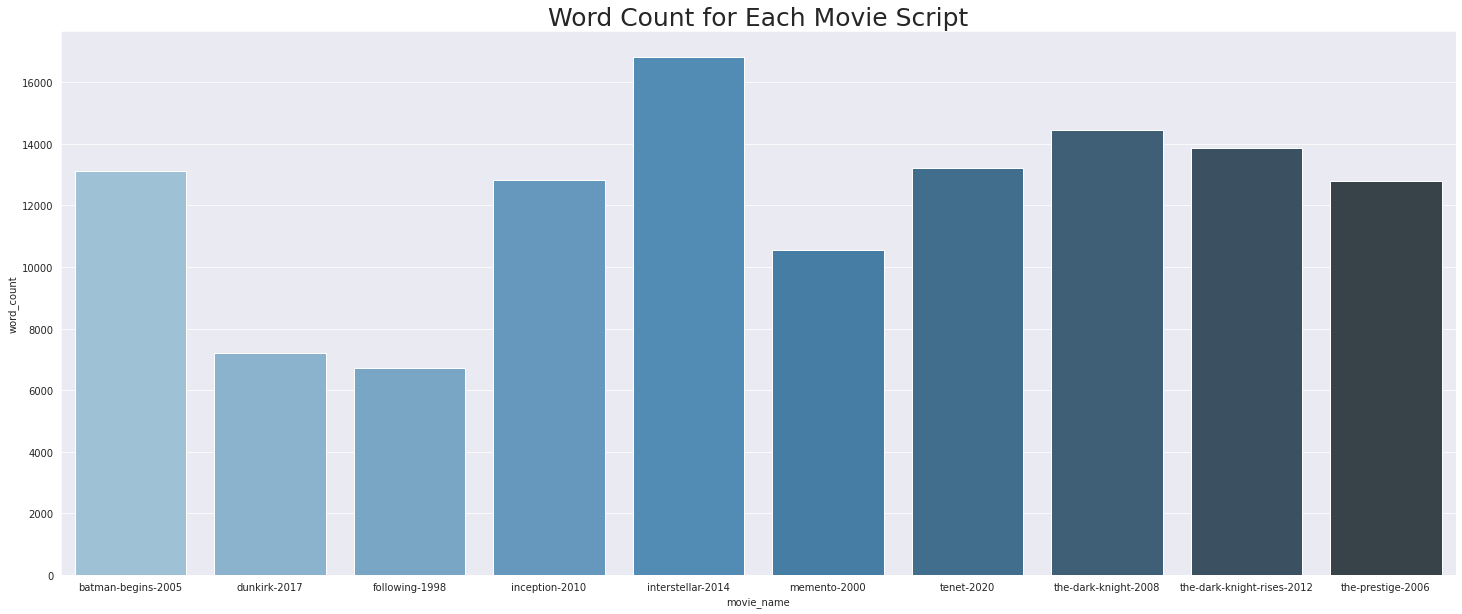

In [8]:
plt.figure(figsize = (25, 10))
fig1 = sns.barplot(x = "movie_name", y = "word_count", data = df, palette = "Blues_d")
fig1.set_title("Word Count for Each Movie Script", fontsize = 25)
fig1.tick_params(labelsize = 10)

In [9]:
# Get the top 30 most common words among all the scripts
def get_top_30(texts):
    p_text = texts

    # Flaten the list of lists
    p_text = [item for sublist in p_text for item in sublist]

    # Top 30
    return(pd.DataFrame(Counter(p_text).most_common(30), columns = ['word', 'frequency']))

texts = df['processed_text']
top_30_1 = get_top_30(texts)
top_30_1

,word,frequency
0,wayne,826
1,leonard,766
2,cobb,689
3,turn,671
4,cooper,624
5,pull,592
6,hand,572
7,door,553
8,take,550
9,batman,528


There are many character names which make of most of the topics and so the topics do not make sense. For eg, one topic only consisted names of characters from The Dark Knight trilogy and this topic only suggests that it belongs to certain movies in the franchise but nothing about the themes present. ( This interpretation is from models run previously with all those words included.) Along with character names, there are other words which individually have no ability to convey any meaning as well. So we will remove them too.

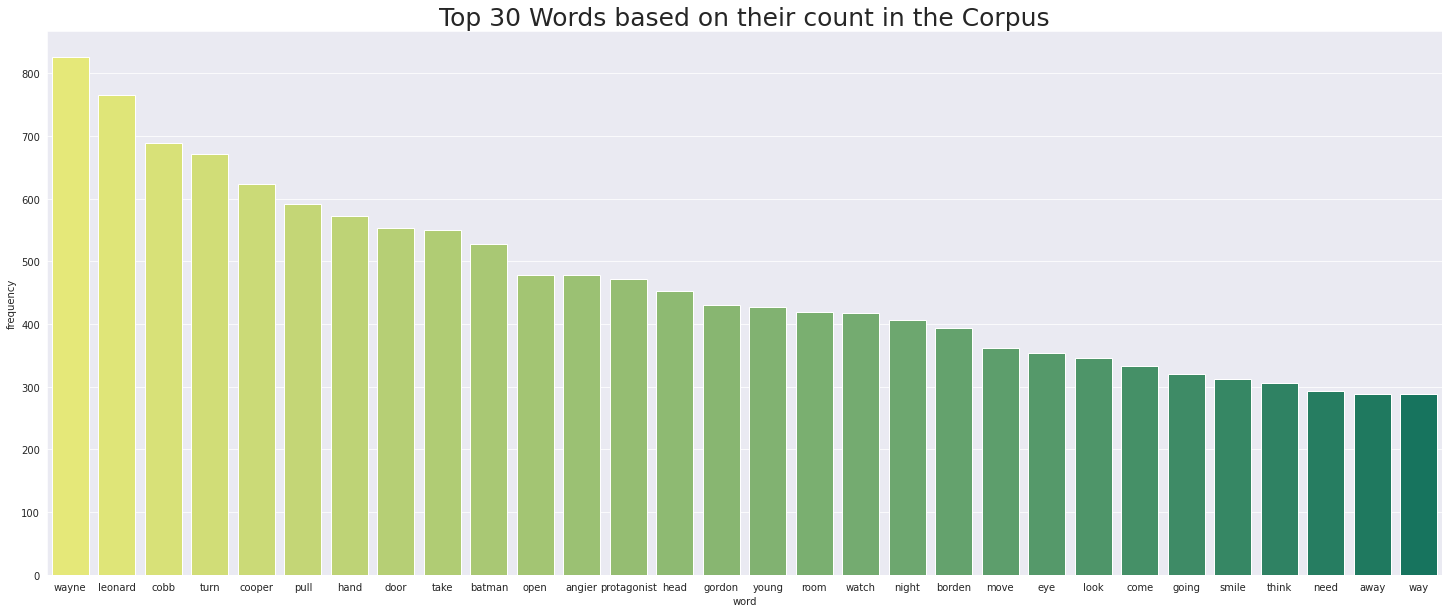

In [10]:
plt.figure(figsize = (25, 10))
fig2 = sns.barplot(x = "word", y = "frequency", data = top_30_1, palette = "summer_r")
fig2.set_title("Top 30 Words based on their count in the Corpus", fontsize = 25)
fig2.tick_params(labelsize = 10)

In [11]:
# Removing character names and other frequent words
freq_words = top_30_1.word.values.tolist()
freq_words.extend(['bruce', 'rachel', 'dent', 'gotham', 'tri', 'jimmy', 'joker', 'john', 'pen', 'harvey', 'fox', 'george', 'peter',
                   'bolton', 'blonde', 'ducard', 'falcone', 'crane', 'alfred', 'robert', 'cutter', 'elevator', 'via', 'bat', 'batmobile', 
                   'martha', 'bat-pod', 'barbara', 'pov', 'thomas', 'loeb', 'mr.wayne', 'bane', 'stephen', 'lucius', 'scarecrow', 
                   'inn', 'brown', 'brand', 'farrier', 'colonel', 'winnant', 'tommy', 'gibson', 'insert', 'cut', 'ackerman', 'james'])
  
def remove_freq_words(text):
    text = [w for w in text if w not in freq_words]
    return text

df['processed_text'] = df['processed_text'].apply(remove_freq_words)

In [12]:
# Form Bigrams
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = nltk.collocations.BigramCollocationFinder.from_documents([script for script in df.processed_text])

# Filter only those that occur at least 15 times
finder.apply_freq_filter(15)
bigram_scores = finder.score_ngrams(bigram_measures.pmi)

bigram_pmi = pd.DataFrame(bigram_scores)
bigram_pmi.columns = ['bigram', 'pmi']
bigram_pmi.sort_values(by = 'pmi', axis = 0, ascending = False, inplace = True)

# Filter for bigrams with only noun-type structures
def bigram_filter(bigram):
    tag = nltk.pos_tag(bigram)
    if tag[0][1] not in ['JJ', 'NN'] and tag[1][1] not in ['NN']:
        return False
    if bigram[0] in stop_words or bigram[1] in stop_words:
        return False
    if 'n' in bigram or 't' in bigram:
        return False
    if 'PRON' in bigram:
        return False
    return True

# Can set pmi threshold to whatever makes sense - eyeball through and select threshold where n-grams stop making sense
filtered_bigram = bigram_pmi[bigram_pmi.apply(lambda bigram:bigram_filter(bigram['bigram']) and bigram.pmi > 5, axis = 1)]
bigrams = [' '.join(x) for x in filtered_bigram.bigram.values if len(x[0]) > 2 or len(x[1]) > 2]

# See bigram examples
bigrams

['hong kong',
 'japanese castle',
 'stock exchange',
 'english channel',
 'snow-covered mountain',
 'base camp',
 'great danton',
 'raise eyebrow',
 'pantage theatre',
 'special force',
 'blackgate prison',
 'moonstone english',
 'cockpit spitfire',
 'underground facility',
 'shivering soldier',
 'chinese colony',
 'sport bag',
 'prewitt building',
 'hospital complex',
 'private deck',
 'year ago',
 'chinese base',
 'ice planet',
 'hotel lobby',
 'moment later',
 'armored car',
 'security guard',
 'spitfire collins',
 'little girl',
 'sator yacht',
 'dark suit',
 'hit button',
 'someone else',
 'piece paper',
 'theatre evening',
 'black hole',
 'lean forward',
 'city hall',
 'bullet hole',
 'deck sator',
 'step forward',
 'say nothing',
 'cop car']

In [13]:
# Concatenate n-grams
def replace_bigram(x):
    for gram in bigrams:
        x = x.replace(gram, '_'.join(gram.split()))
    return x.split()

df['processed_text_w_bigrams'] = df.processed_text.apply((' ').join).apply(replace_bigram)
df

,movie_name,script,processed_text,word_count,processed_text_w_bigrams
0,batman-begins-2005,By BLACK. A low KEENING which becomes SCREECHI...,"[black, low, keening, becomes, screeching, bui...",13129,"[black, low, keening, becomes, screeching, bui..."
1,dunkirk-2017,Dunkirk Written by Christopher Nolan Transferr...,"[transferred, complete, selected, storyboards,...",7216,"[transferred, complete, selected, storyboards,..."
2,following-1998,Written by Christopher Nolan EXT. CROWDED LOND...,"[crowded, london, street, endless, stream, ped...",6723,"[crowded, london, street, endless, stream, ped..."
3,inception-2010,By Christopher Nolan The waves TOSS a BEARDED ...,"[wave, toss, bearded, wet, sand, lie, child, s...",12813,"[wave, toss, bearded, wet, sand, lie, child, s..."
4,interstellar-2014,interstellar_d2.0_FINAL.pdf Interstellar writt...,"[interstellar_d._final.pdf, story, kip, thorne...",16817,"[interstellar_d._final.pdf, story, kip, thorne..."
5,memento-2000,Memento A Screenplay by Christopher Nolan Base...,"[based, short, story, short, story, ,,,,-,,,,,...",10544,"[based, short, story, short, story, ,,,,-,,,,,..."
6,tenet-2020,Tenet by Christopher Nolan Written by Christop...,"[orchestra, tuning, audience, settling, high, ...",13220,"[orchestra, tuning, audience, settling, high, ..."
7,the-dark-knight-2008,TDK Final Draft Title Page by Jonathan Nolan a...,"[final, title, story, david, goyer, created, b...",14448,"[final, title, story, david, goyer, created, b..."
8,the-dark-knight-rises-2012,by Jonathan Nolan and Christopher Nolan Story ...,"[story, david, goyer, based, upon, character, ...",13864,"[story, david, goyer, based, upon, character, ..."
9,the-prestige-2006,The Prestige.SCW TOP HATS. Clustered in a sma...,"[top, hat, clustered, small, glade, super, tit...",12784,"[top, hat, clustered, small, glade, super, tit..."


In [14]:
# Word count for each script after adding bigrams
df['word_count_w_bigrams'] = df['processed_text_w_bigrams'].apply(lambda x: len(str(x).split(" ")))
df

,movie_name,script,processed_text,word_count,processed_text_w_bigrams,word_count_w_bigrams
0,batman-begins-2005,By BLACK. A low KEENING which becomes SCREECHI...,"[black, low, keening, becomes, screeching, bui...",13129,"[black, low, keening, becomes, screeching, bui...",10552
1,dunkirk-2017,Dunkirk Written by Christopher Nolan Transferr...,"[transferred, complete, selected, storyboards,...",7216,"[transferred, complete, selected, storyboards,...",6124
2,following-1998,Written by Christopher Nolan EXT. CROWDED LOND...,"[crowded, london, street, endless, stream, ped...",6723,"[crowded, london, street, endless, stream, ped...",5521
3,inception-2010,By Christopher Nolan The waves TOSS a BEARDED ...,"[wave, toss, bearded, wet, sand, lie, child, s...",12813,"[wave, toss, bearded, wet, sand, lie, child, s...",11006
4,interstellar-2014,interstellar_d2.0_FINAL.pdf Interstellar writt...,"[interstellar_d._final.pdf, story, kip, thorne...",16817,"[interstellar_d._final.pdf, story, kip, thorne...",14696
5,memento-2000,Memento A Screenplay by Christopher Nolan Base...,"[based, short, story, short, story, ,,,,-,,,,,...",10544,"[based, short, story, short, story, ,,,,-,,,,,...",8778
6,tenet-2020,Tenet by Christopher Nolan Written by Christop...,"[orchestra, tuning, audience, settling, high, ...",13220,"[orchestra, tuning, audience, settling, high, ...",11712
7,the-dark-knight-2008,TDK Final Draft Title Page by Jonathan Nolan a...,"[final, title, story, david, goyer, created, b...",14448,"[final, title, story, david, goyer, created, b...",11732
8,the-dark-knight-rises-2012,by Jonathan Nolan and Christopher Nolan Story ...,"[story, david, goyer, based, upon, character, ...",13864,"[story, david, goyer, based, upon, character, ...",11688
9,the-prestige-2006,The Prestige.SCW TOP HATS. Clustered in a sma...,"[top, hat, clustered, small, glade, super, tit...",12784,"[top, hat, clustered, small, glade, super, tit...",10642


In [15]:
# Filter words based on parts of speech tags
def imp_pos_only(x):
    pos_script = nltk.pos_tag(x)

    # To filter only nouns
    #filtered = [word[0] for word in pos_script if word[1] in ['NN']] 

    # To filter both nouns and verbs
    filtered = [word[0] for word in pos_script if word[1] in ['NN', 'VB', 'VBD', 'VBG', 'VBN', 'VBZ']]
    return filtered

df['processed_text'] = df['processed_text'].apply(imp_pos_only)
texts = df['processed_text']
top_30_2 = get_top_30(texts)
top_30_2

,word,frequency
0,car,286
1,step,274
2,street,274
3,time,262
4,something,258
5,got,249
6,face,244
7,water,239
8,thing,230
9,gun,223


In [16]:
# Get the number of unique words after processing
texts = df['processed_text_w_bigrams']
f_text = [item for sublist in texts for item in sublist]
num_unique_words = len(set(f_text))
num_unique_words

11764

Topic Modeling using **Non - Negative Matrix Factorization (NMF)**

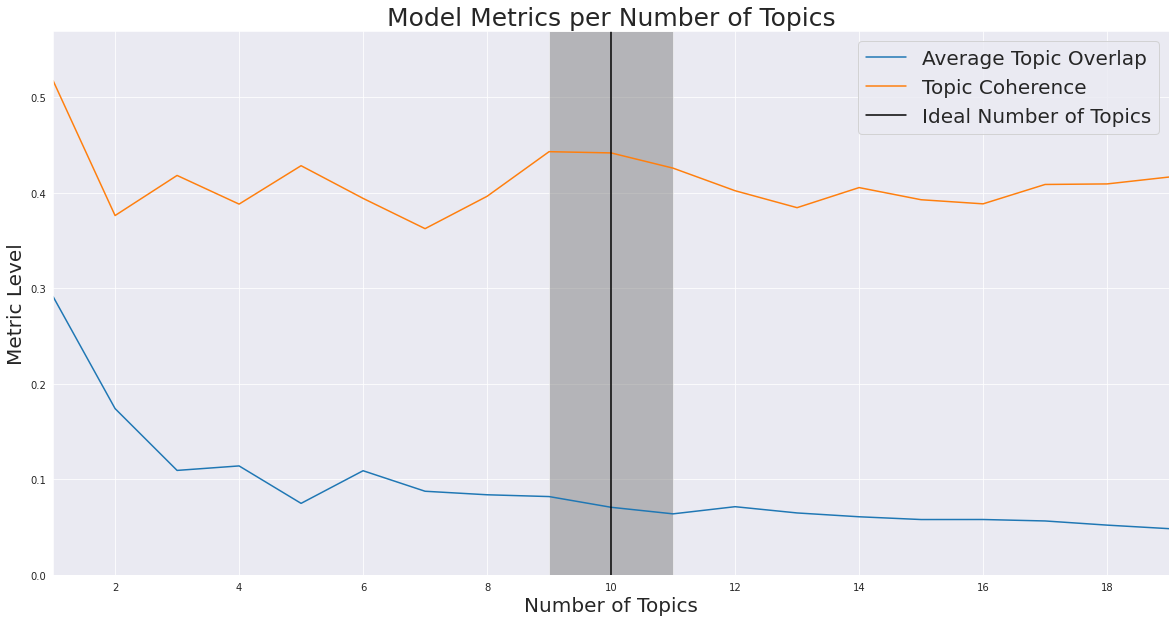

In [17]:
# Use Gensim's NMF to get the best num of topics via maximising coherence score and minimising jaccard similarity
texts = df['processed_text_w_bigrams']

# Create a dictionary
dictionary = Dictionary(texts)

# Filter out extremes to limit the number of features
dictionary.filter_extremes(no_below = 2, no_above = 0.90, keep_n = 10000)

# Create bag-of-words format (list of (token_id, token_count))
corpus = [dictionary.doc2bow(text) for text in texts]

# Calculate TF-IDF from bag of words
tfidf = models.TfidfModel(corpus)
tfidf_corpus = tfidf[corpus]

# Considering 1-20 topics, as the last is cut off
num_topics = list(range(21)[1:])
num_keywords = 15

NMF_models = {}
NMF_topics = {}
for i in num_topics:
    NMF_models[i] = Nmf(
                    corpus = tfidf_corpus,
                    num_topics = i,
                    id2word = dictionary,
                    chunksize = 2000,
                    passes = 5,
                    random_state = 42)

    shown_topics = NMF_models[i].show_topics(num_topics = i, num_words = num_keywords, formatted = False)
    NMF_topics[i] = [[word[0] for word in topic[1]] for topic in shown_topics]

# A function to derive the Jaccard similarity of two topics:
def jaccard_similarity(topic_1, topic_2):
    """
    Derives the Jaccard similarity of two topics

    Jaccard similarity:
    - A statistic used for comparing the similarity and diversity of sample sets
    - J(A,B) = (A ∩ B)/(A ∪ B)
    - Goal is low Jaccard scores for coverage of the diverse elements
    """
    intersection = set(topic_1).intersection(set(topic_2))
    union = set(topic_1).union(set(topic_2))
                    
    return float(len(intersection))/float(len(union))


# Using the above to derive the mean stability across topics by considering the next topic:

NMF_stability = {}
for i in range(0, len(num_topics)-1):
    jaccard_sims = []
    for t1, topic1 in enumerate(NMF_topics[num_topics[i]]):
        sims = []
        for t2, topic2 in enumerate(NMF_topics[num_topics[i+1]]):
            sims.append(jaccard_similarity(topic1, topic2))    
        
        jaccard_sims.append(sims)    
    
    NMF_stability[num_topics[i]] = jaccard_sims
                
mean_stabilities = [np.array(NMF_stability[i]).mean() for i in num_topics[:-1]]

# Calculate coherence scores
coherences = [CoherenceModel(model = NMF_models[i], texts = texts, dictionary = dictionary, coherence =  'c_v').get_coherence() for i in num_topics[:-1]]

# From here derive the ideal number of topics roughly through the difference between the coherence and stability per number of topics
coh_sta_diffs = [coherences[i] - mean_stabilities[i] for i in range(num_keywords)[:-1]] # limit topic numbers to the number of keywords
coh_sta_max = max(coh_sta_diffs)
coh_sta_max_idxs = [i for i, j in enumerate(coh_sta_diffs) if j == coh_sta_max]
ideal_topic_num_index = coh_sta_max_idxs[0] # choose less topics in case there's more than one max
ideal_topic_num = num_topics[ideal_topic_num_index]

# Finally graph these metrics across the topic numbers
plt.figure(figsize = (20, 10))
fig3 = sns.lineplot(x = num_topics[:-1], y = mean_stabilities, label = 'Average Topic Overlap')
fig3 = sns.lineplot(x = num_topics[:-1], y = coherences, label = 'Topic Coherence')

fig3.axvline(x = ideal_topic_num, label = 'Ideal Number of Topics', color = 'black')
fig3.axvspan(xmin = ideal_topic_num - 1, xmax = ideal_topic_num + 1, alpha = 0.5, facecolor = 'grey')

y_max = max(max(mean_stabilities), max(coherences)) + (0.10 * max(max(mean_stabilities), max(coherences)))
fig3.set_ylim([0, y_max])
fig3.set_xlim([1, num_topics[-1]-1])
                
fig3.axes.set_title('Model Metrics per Number of Topics', fontsize = 25)
fig3.set_ylabel('Metric Level', fontsize = 20)
fig3.set_xlabel('Number of Topics', fontsize = 20)
plt.legend(fontsize = 20)
plt.show()

In [18]:
# Compute Perplexity
#print('\nPerplexity of NMF model: ', NMF_models[10]_perplexity(corpus))  # A measure of how good the model is; lower the better

In [19]:
# Taking a look at the topics of the best model suggested by the previous graph
pprint(NMF_models[10].print_topics())

[(0,
  '0.014*"ferry" + 0.013*"penthouse" + 0.011*"cop" + 0.011*"swat" + '
  '0.010*"clown" + 0.009*"mayor" + 0.008*"central" + 0.006*"detective" + '
  '0.006*"lounge" + 0.005*"prisoner"'),
 (1,
  '0.012*"condition" + 0.010*"license" + 0.010*"discount" + 0.009*"photo" + '
  '0.009*"message" + 0.009*"memory" + 0.009*"pickup" + 0.007*"drug" + '
  '0.007*"car" + 0.006*"trailer"'),
 (2,
  '0.020*"mercenary" + 0.015*"dark_suit" + 0.010*"prisoner" + 0.007*"cop" + '
  '0.006*"sewer" + 0.006*"manor" + 0.006*"thug" + 0.006*"café" + '
  '0.005*"enterprise" + 0.004*"maid"'),
 (3,
  '0.011*"thug" + 0.011*"cop" + 0.006*"grappling" + 0.006*"homeless" + '
  '0.006*"cop_car" + 0.005*"limo" + 0.004*"inmate" + 0.004*"technician" + '
  '0.004*"symbol" + 0.003*"birthday"'),
 (4,
  '0.021*"black_hole" + 0.015*"planet" + 0.012*"mission" + 0.011*"ship" + '
  '0.009*"star" + 0.009*"orbit" + 0.008*"endurance" + 0.008*"earth" + '
  '0.007*"hull" + 0.007*"creature"'),
 (5,
  '0.012*"recording" + 0.010*"vault" + 

In [20]:
# Visualizing top 10 words and their weights in each topic 
n_words = 10

topic_words = pd.DataFrame({})

for i, topic in enumerate(NMF_models[10].get_topics()):
    top_feature_ids = topic.argsort()[-n_words:][::-1]
    feature_values = topic[top_feature_ids]
    words = [dictionary[id] for id in top_feature_ids]
    topic_df = pd.DataFrame({'value': feature_values, 'word': words, 'topic': i})
    topic_words = pd.concat([topic_words, topic_df], ignore_index = True)

topic_words.head()

,value,word,topic
0,0.013551,ferry,0
1,0.012579,penthouse,0
2,0.011136,cop,0
3,0.011115,swat,0
4,0.009863,clown,0


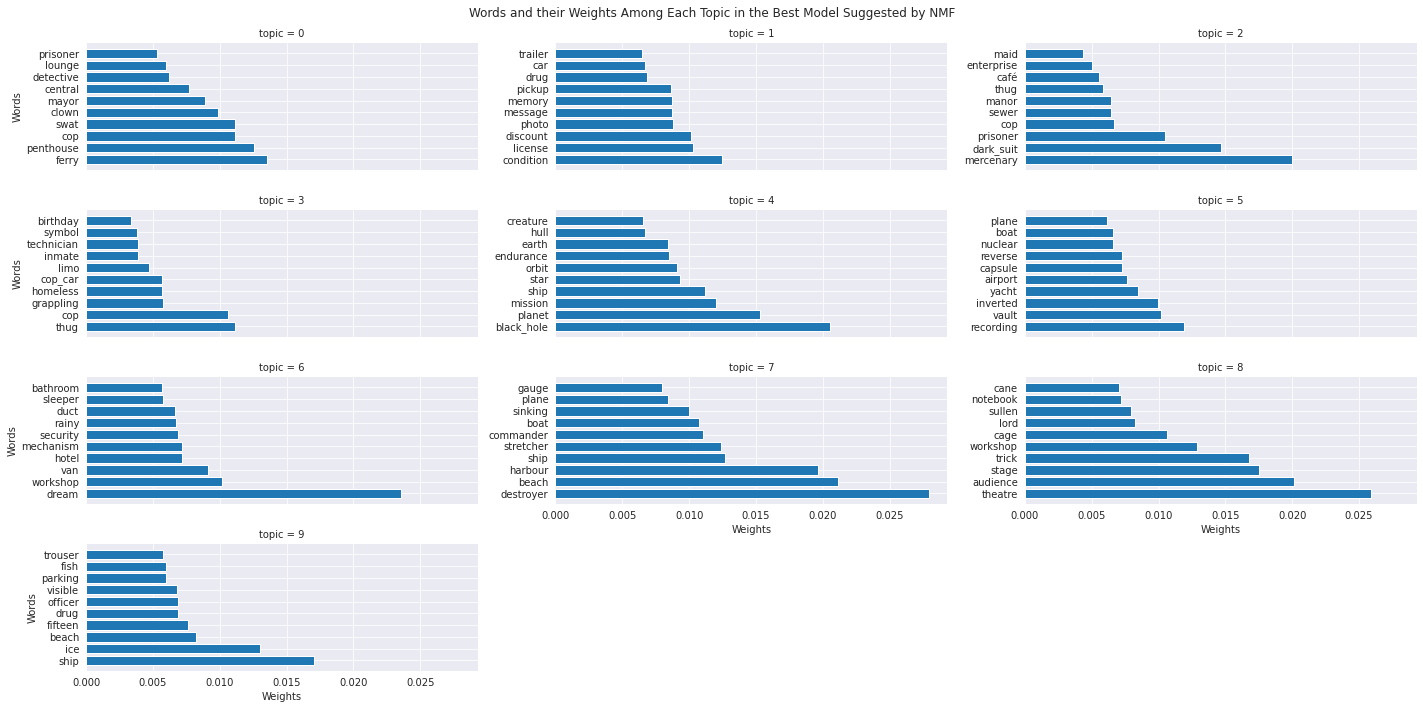

In [21]:
fig4 = sns.FacetGrid(topic_words, col = "topic", col_wrap = 3, sharey = False, height = 2.5, aspect = 2.65)
fig4.map(plt.barh, "word", "value")
fig4.set_xlabels("Weights")
fig4.set_ylabels("Words")
fig4.fig.suptitle('Words and their Weights Among Each Topic in the Best Model Suggested by NMF')
plt.subplots_adjust(top = 0.93)
plt.show()

In [22]:
# Finding the dominant topic in each script
def finding_dominant_topic(model, corpus):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(model[corpus]):
        row = sorted(row, key = lambda x: (x[1]), reverse = True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = model.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic, 4), topic_keywords]), ignore_index = True)
            else:
                break
    sent_topics_df.columns = ['dominant_topic', 'perc_contribution', 'topic_keywords']
    return(sent_topics_df)

sent_topics_df = finding_dominant_topic(model = NMF_models[10], corpus = corpus)

# Add original dataframe to topic_df
sent_topics_df = pd.concat([df, sent_topics_df], axis = 1)
sent_topics_df.reset_index(drop = True, inplace = True)
df_dominant_topic = sent_topics_df[['movie_name', 'dominant_topic', 'perc_contribution', 'topic_keywords', 'script', 'processed_text', 'word_count']]
                                   
# Show
df_dominant_topic

,movie_name,dominant_topic,perc_contribution,topic_keywords,script,processed_text,word_count
0,batman-begins-2005,9.0,0.4629,"ship, ice, beach, fifteen, drug, officer, visi...",By BLACK. A low KEENING which becomes SCREECHI...,"[keening, screeching, flicker, screen, life, c...",13129
1,dunkirk-2017,7.0,0.8043,"destroyer, beach, harbour, ship, stretcher, co...",Dunkirk Written by Christopher Nolan Transferr...,"[transferred, selected, published, water, slap...",7216
2,following-1998,9.0,0.3486,"ship, ice, beach, fifteen, drug, officer, visi...",Written by Christopher Nolan EXT. CROWDED LOND...,"[crowded, street, stream, crossing, frame, loo...",6723
3,inception-2010,6.0,0.6552,"dream, workshop, van, hotel, mechanism, securi...",By Christopher Nolan The waves TOSS a BEARDED ...,"[wave, toss, bearded, sand, lie, child, shout,...",12813
4,interstellar-2014,4.0,0.4468,"black_hole, planet, mission, ship, star, orbit...",interstellar_d2.0_FINAL.pdf Interstellar writt...,"[story, kip, lynda, march, dark, corner, used,...",16817
5,memento-2000,1.0,0.7168,"condition, license, discount, photo, message, ...",Memento A Screenplay by Christopher Nolan Base...,"[based, story, story, ,a,,,,,,,a,,a,,a, shooti...",10544
6,tenet-2020,5.0,0.6532,"recording, vault, inverted, yacht, airport, ca...",Tenet by Christopher Nolan Written by Christop...,"[tuning, audience, settling, box, closing, bam...",13220
7,the-dark-knight-2008,0.0,0.5395,"ferry, penthouse, cop, swat, clown, mayor, cen...",TDK Final Draft Title Page by Jonathan Nolan a...,"[title, story, david, goyer, created, kane, bu...",14448
8,the-dark-knight-rises-2012,0.0,0.2619,"ferry, penthouse, cop, swat, clown, mayor, cen...",by Jonathan Nolan and Christopher Nolan Story ...,"[story, david, goyer, based, character, appear...",13864
9,the-prestige-2006,8.0,0.5745,"theatre, audience, stage, trick, workshop, cag...",The Prestige.SCW TOP HATS. Clustered in a sma...,"[hat, clustered, glade, title, cat, watching, ...",12784


Topic Modeling using **Latent Dirichlet Allocation (LDA)**

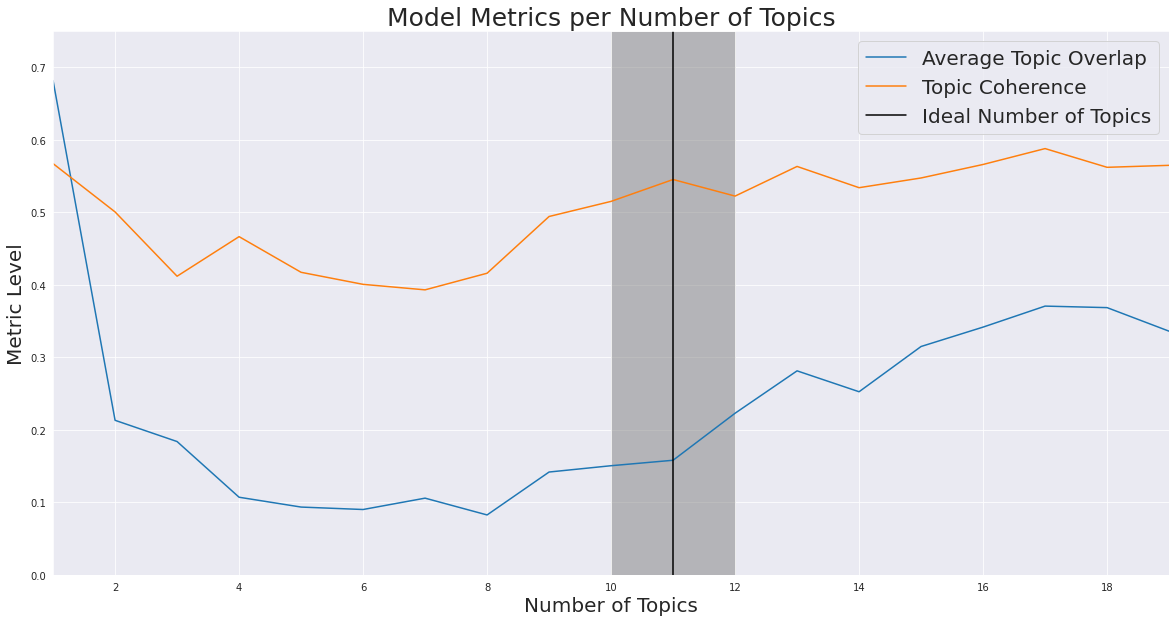

In [23]:
# Use Gensim's LDA to get the best num of topics via maximising coherence score and minimising jaccard similarity
texts = df['processed_text_w_bigrams']

# Create a dictionary
dictionary = Dictionary(texts)

# Filter out extremes to limit the number of features
dictionary.filter_extremes(no_below = 2, no_above = 0.90, keep_n = 10000)

# Create bag-of-words format (list of (token_id, token_count))
corpus = [dictionary.doc2bow(text) for text in texts]

# Calculate TF-IDF from bag of words
tfidf = models.TfidfModel(corpus)
tfidf_corpus = tfidf[corpus]

# Considering 2-20 topics, as the last is cut off
num_topics = list(range(21)[1:])
num_keywords = 15

LDA_models = {}
LDA_topics = {}
for i in num_topics:
    LDA_models[i] = LdaModel(
                    corpus = tfidf_corpus,
                    id2word = dictionary,
                    num_topics = i,
                    update_every = 1,
                    chunksize = 2000,
                    passes = 20,
                    iterations = 200,
                    alpha = 'auto',
                    random_state = 42)

    shown_topics = LDA_models[i].show_topics(num_topics = i, num_words = num_keywords, formatted = False)
    LDA_topics[i] = [[word[0] for word in topic[1]] for topic in shown_topics]

# Using the jaccard similarity function to derive the mean stability across topics by considering the next topic:

LDA_stability = {}
for i in range(0, len(num_topics) - 1):
    jaccard_sims = []
    for t1, topic1 in enumerate(LDA_topics[num_topics[i]]):
        sims = []
        for t2, topic2 in enumerate(LDA_topics[num_topics[i + 1]]):
            sims.append(jaccard_similarity(topic1, topic2))    
        
        jaccard_sims.append(sims)    
    
    LDA_stability[num_topics[i]] = jaccard_sims
                
mean_stabilities = [np.array(LDA_stability[i]).mean() for i in num_topics[:-1]]

# Calculate coherence scores
coherences = [CoherenceModel(model = LDA_models[i], texts = texts, dictionary = dictionary, coherence =  'c_v').get_coherence() for i in num_topics[:-1]]

# From here derive the ideal number of topics roughly through the difference between the coherence and stability per number of topics
coh_sta_diffs = [coherences[i] - mean_stabilities[i] for i in range(num_keywords)[:-1]] # limit topic numbers to the number of keywords
coh_sta_max = max(coh_sta_diffs)
coh_sta_max_idxs = [i for i, j in enumerate(coh_sta_diffs) if j == coh_sta_max]
ideal_topic_num_index = coh_sta_max_idxs[0] # choose less topics in case there's more than one max
ideal_topic_num = num_topics[ideal_topic_num_index]

# Finally graph these metrics across the topic numbers
plt.figure(figsize = (20, 10))
fig5 = sns.lineplot(x = num_topics[:-1], y = mean_stabilities, label = 'Average Topic Overlap')
fig5 = sns.lineplot(x = num_topics[:-1], y = coherences, label = 'Topic Coherence')

fig5.axvline(x = ideal_topic_num, label = 'Ideal Number of Topics', color = 'black')
fig5.axvspan(xmin = ideal_topic_num - 1, xmax = ideal_topic_num + 1, alpha = 0.5, facecolor = 'grey')

y_max = max(max(mean_stabilities), max(coherences)) + (0.10 * max(max(mean_stabilities), max(coherences)))
fig5.set_ylim([0, y_max])
fig5.set_xlim([1, num_topics[-1]-1])
                
fig5.axes.set_title('Model Metrics per Number of Topics', fontsize = 25)
fig5.set_ylabel('Metric Level', fontsize = 20)
fig5.set_xlabel('Number of Topics', fontsize = 20)
plt.legend(fontsize = 20)
plt.show()

In [40]:
# Compute Perplexity
print('\nPerplexity of LDA model: ', LDA_models[11].log_perplexity(corpus))  # A measure of how good the model is; lower the better


Perplexity of LDA model:  -15.808202864580526


In [35]:
# Taking a look at the topics of the best model suggested by the previous graph
pprint(LDA_models[11].print_topics())

[(0,
  '0.000*"thief" + 0.000*"tension" + 0.000*"tossing" + 0.000*"tortured" + '
  '0.000*"tool" + 0.000*"tired" + 0.000*"thoughtful" + 0.000*"though" + '
  '0.000*"totally" + 0.000*"terraced"'),
 (1,
  '0.001*"mercenary" + 0.001*"dream" + 0.001*"prisoner" + 0.001*"recording" + '
  '0.001*"swat" + 0.001*"vault" + 0.001*"inverted" + 0.001*"workshop" + '
  '0.001*"van" + 0.001*"thug"'),
 (2,
  '0.002*"dark_suit" + 0.001*"writer" + 0.001*"café" + 0.001*"shelf" + '
  '0.001*"hammer" + 0.001*"hair" + 0.000*"bald" + 0.000*"photo" + '
  '0.000*"unshaven" + 0.000*"sunglass"'),
 (3,
  '0.001*"black_hole" + 0.001*"planet" + 0.001*"ship" + 0.001*"mission" + '
  '0.001*"star" + 0.001*"orbit" + 0.001*"endurance" + 0.001*"earth" + '
  '0.001*"hull" + 0.000*"ice"'),
 (4,
  '0.001*"destroyer" + 0.001*"beach" + 0.001*"harbour" + 0.001*"ship" + '
  '0.001*"stretcher" + 0.001*"boat" + 0.001*"commander" + 0.001*"plane" + '
  '0.001*"sinking" + 0.000*"gauge"'),
 (5,
  '0.000*"thief" + 0.000*"tension" + 0.0

In [41]:
# Visualizing top 10 words and their weights in each topic
n_words = 10

topic_words = pd.DataFrame({})

for i, topic in enumerate(LDA_models[11].get_topics()):
    top_feature_ids = topic.argsort()[-n_words:][::-1]
    feature_values = topic[top_feature_ids]
    words = [dictionary[id] for id in top_feature_ids]
    topic_df = pd.DataFrame({'value': feature_values, 'word': words, 'topic': i})
    topic_words = pd.concat([topic_words, topic_df], ignore_index = True)

topic_words.head()

,value,word,topic
0,0.000201,vice,0
1,0.000201,rachel-,0
2,0.000201,quality,0
3,0.000201,question,0
4,0.000201,questioning,0


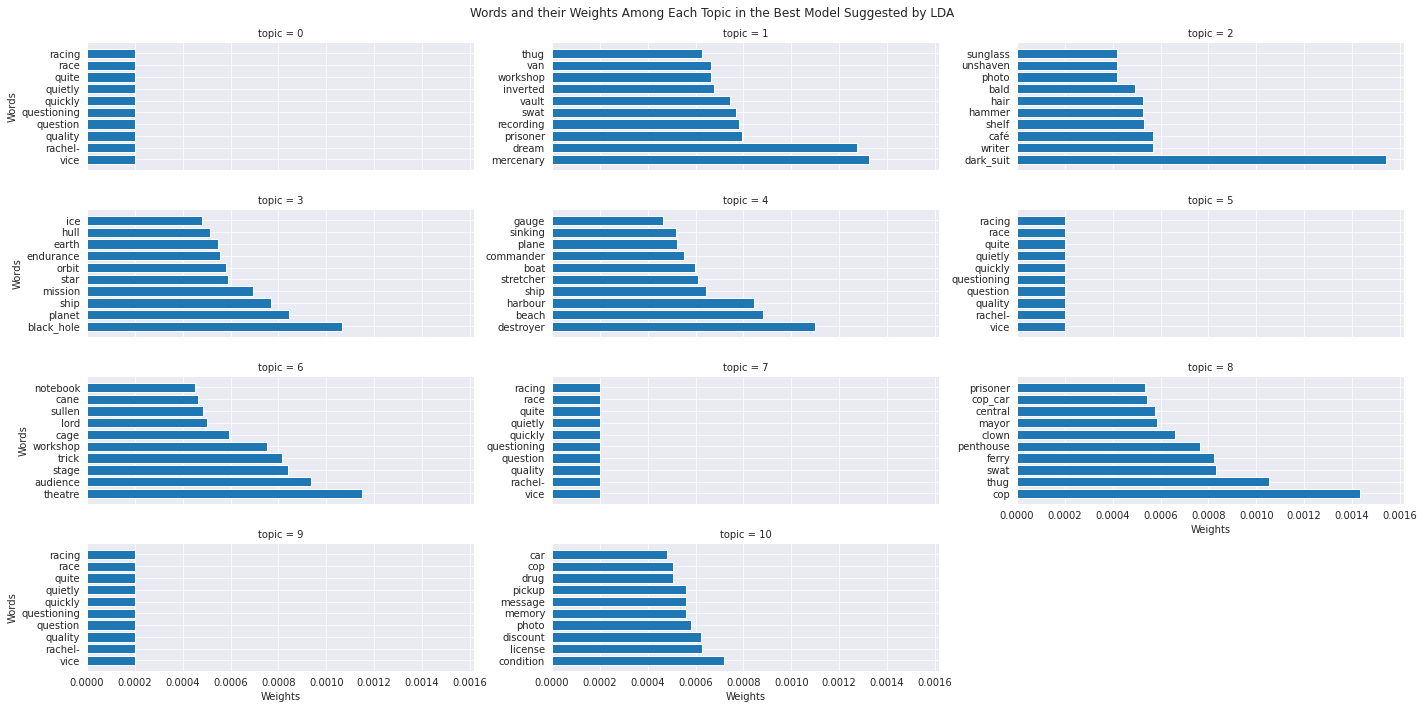

In [42]:
fig6 = sns.FacetGrid(topic_words, col = "topic", col_wrap = 3, sharey = False, height = 2.5, aspect = 2.65)
fig6.map(plt.barh, "word", "value")
fig6.set_xlabels("Weights")
fig6.set_ylabels("Words")
fig6.fig.suptitle('Words and their Weights Among Each Topic in the Best Model Suggested by LDA')
plt.subplots_adjust(top = 0.93)
plt.show()

In [43]:
pyLDAvis.enable_notebook()
fig7 = pyLDAvis.gensim_models.prepare(LDA_models[11], corpus, dictionary, mds = 'mmds')
fig7

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.003250  0.002445       1        1  41.251948
8     -0.000303 -0.003085       2        1  20.578757
3     -0.000973 -0.000575       3        1  11.350546
6     -0.000172  0.001126       4        1   8.753622
10     0.001597 -0.000869       5        1   8.019964
4      0.001396 -0.000015       6        1   5.209080
2      0.000953  0.001073       7        1   4.832557
0      0.000174 -0.000043       8        1   0.000881
5      0.000171 -0.000042       9        1   0.000881
7      0.000204 -0.000007      10        1   0.000881
9      0.000203 -0.000008      11        1   0.000881, topic_info=            Term     Freq      Total Category  logprob  loglift
1352   mercenary  37.0000  37.000000  Default  30.0000  30.0000
638        dream  36.0000  36.000000  Default  29.0000  29.0000
2129        swat  31.0000  31.000000  Default  28.0000  28.0000
446          cop  35.0000  35.000000  Default  27.0000  27.0000
1613    prisoner  28.0000  28.000000  Default  26.0000  26.0000
...          ...      ...        ...      ...      ...      ...
25         agent   0.0001  10.916718  Topic11  -8.5108   0.0369
26    aggressive   0.0001  10.878471  Topic11  -8.5108   0.0404
27         agony   0.0001  10.920963  Topic11  -8.5108   0.0365
28        ahead-   0.0001  10.931498  Topic11  -8.5108   0.0355
29           aim   0.0001  11.023880  Topic11  -8.5108   0.0271

[507 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
0         1  0.354978   -and
0         2  0.266233   -and
0         3  0.088744   -and
0         4  0.088744   -and
0         5  0.088744   -and
...     ...       ...    ...
2922      3  0.052681  yacht
2922      4  0.052681  yacht
2922      5  0.052681  yacht
2922      6  0.052681  yacht
2922      7  0.052681  yacht

[1974 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 9, 4, 7, 11, 5, 3, 1, 6, 8, 10])

In [45]:
# Finding the dominant topic in each script
sent_topics_df = finding_dominant_topic(model = LDA_models[11], corpus = corpus)

# Add original dataframe to topic_df
sent_topics_df = pd.concat([df, sent_topics_df], axis = 1)
sent_topics_df.reset_index(drop = True, inplace = True)
df_dominant_topic = sent_topics_df[['movie_name', 'dominant_topic', 'perc_contribution', 'topic_keywords', 'script', 'processed_text', 'word_count']]
                                   
# Show
df_dominant_topic

,movie_name,dominant_topic,perc_contribution,topic_keywords,script,processed_text,word_count
0,batman-begins-2005,8.0,0.8480,"cop, thug, swat, ferry, penthouse, clown, mayo...",By BLACK. A low KEENING which becomes SCREECHI...,"[keening, screeching, flicker, screen, life, c...",13129
1,dunkirk-2017,4.0,0.8813,"destroyer, beach, harbour, ship, stretcher, bo...",Dunkirk Written by Christopher Nolan Transferr...,"[transferred, selected, published, water, slap...",7216
2,following-1998,2.0,0.9038,"dark_suit, writer, café, shelf, hammer, hair, ...",Written by Christopher Nolan EXT. CROWDED LOND...,"[crowded, street, stream, crossing, frame, loo...",6723
3,inception-2010,1.0,0.9947,"mercenary, dream, prisoner, recording, swat, v...",By Christopher Nolan The waves TOSS a BEARDED ...,"[wave, toss, bearded, sand, lie, child, shout,...",12813
4,interstellar-2014,3.0,0.7846,"black_hole, planet, ship, mission, star, orbit...",interstellar_d2.0_FINAL.pdf Interstellar writt...,"[story, kip, lynda, march, dark, corner, used,...",16817
5,memento-2000,10.0,0.9322,"condition, license, discount, photo, memory, m...",Memento A Screenplay by Christopher Nolan Base...,"[based, story, story, ,a,,,,,,,a,,a,,a, shooti...",10544
6,tenet-2020,1.0,0.9852,"mercenary, dream, prisoner, recording, swat, v...",Tenet by Christopher Nolan Written by Christop...,"[tuning, audience, settling, box, closing, bam...",13220
7,the-dark-knight-2008,8.0,0.7531,"cop, thug, swat, ferry, penthouse, clown, mayo...",TDK Final Draft Title Page by Jonathan Nolan a...,"[title, story, david, goyer, created, kane, bu...",14448
8,the-dark-knight-rises-2012,1.0,0.8570,"mercenary, dream, prisoner, recording, swat, v...",by Jonathan Nolan and Christopher Nolan Story ...,"[story, david, goyer, based, character, appear...",13864
9,the-prestige-2006,6.0,0.8553,"theatre, audience, stage, trick, workshop, cag...",The Prestige.SCW TOP HATS. Clustered in a sma...,"[hat, clustered, glade, title, cat, watching, ...",12784


Topic Modeling using Biterm (BTM)

In [46]:
texts = df['processed_text_w_bigrams']
texts = [(' ').join(sublist) for sublist in texts]

In [47]:
# Preprocessing
# Obtaining terms frequency in a sparse matrix and corpus vocabulary
X, vocabulary, vocab_dict = btm.get_words_freqs(texts)
tf = np.array(X.sum(axis=0)).ravel()

# Vectorizing documents
docs_vec = btm.get_vectorized_docs(texts, vocabulary)
docs_lens = list(map(len, docs_vec))

# Generating biterms
biterms = btm.get_biterms(docs_vec)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [32]:
# Initialising and running the model
model = btm.BTM(X, vocabulary, seed = 12321, T = 10, M = 20, alpha = 50/8, beta = 0.01)
model.fit(biterms, iterations = 20)
p_zd = model.transform(docs_vec)

100%|██████████| 10/10 [00:00<00:00, 89.17it/s]


In [33]:
# Metrics
print("Perplexity of BTM Model", model.perplexity_)
print("Coherence of BTM Model", model.coherence_)

Perplexity of BTM Model 1214.0529274068176
Coherence of BTM Model [-52.21006971  65.71560861  29.43169054  -4.12049162  -3.89355093
  11.05025955   6.5392242   42.95539234 -12.65918954          inf]


In [48]:
# Run the interactive report interface
tmp.report(model = model, docs = texts)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning,
